<a href="https://colab.research.google.com/github/marinasjp/pytorchFL/blob/master/resnet34FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
Start Round 1 ...
1 2.6485483187128613 2.156119750022888 27.59493670886076 27.59493670886076
Start Round 2 ...
2 1.8847864487293682 1.7605862741470337 40.88607594936709 40.88607594936709
Start Round 3 ...
3 1.6771632560725898 1.683108135986328 42.151898734177216 42.151898734177216
Start Round 4 ...
4 1.5198182591589955 1.6150505708694458 53.037974683544306 53.037974683544306
Start Round 5 ...
5 1.4696314152704948 1.498228014755249 50.75949367088607 53.037974683544306
Start Round 6 ...
6 1.3980083087366766 1.4782595830917358 58.22784810126582 58.22784810126582
Start Round 7 ...
7 1.303059824077498 1.3683025547027587 57.46835443037975 58.22784810126582
Start Round 8 ...
8 1.3053185352351566 1.3844614084243774 59.620253164556964 59.620253164556964
Start Round 9 ...
9 1.283541547699892 1.3025754543304444 62.0253164556962 62.0253164556962
Start Round 10 ...
10 1.2323945232262545 1.1975538652420044 66.07594936708861 

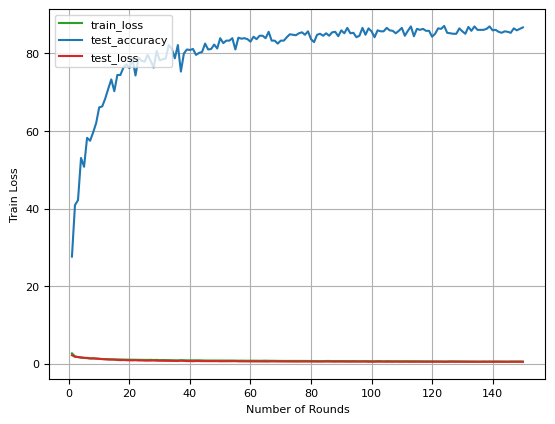

In [3]:
import copy

import matplotlib

import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split, DataLoader, Subset, Dataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision.models import resnet, resnet34

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

IMAGE_SIZE = 32
composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize the image in a 32X32 shape
                                     transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
                                     transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
                                     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                                                            contrast = 0.1,
                                                            saturation = 0.1),
                                     transforms.RandomAdjustSharpness(sharpness_factor = 2,
                                                                      p = 0.1), # Randomly adjust sharpness
                                     transforms.ToTensor(),  # Converting image to tensor
                                     transforms.Normalize(mean, std),
                                     # Normalizing with standard mean and standard deviation
                                     transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0, inplace=False)])

composed_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

train_dataset = CIFAR10('./', train=True, download=True, transform=composed_train)
test_dataset = CIFAR10('./', train=False, download=True, transform=composed_test)
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)

# Create train and validation batch for training
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100)

data_iterable = iter(train_loader)  # converting our train_dataloader to iterable so that we can iter through it.
images, labels = next(data_iterable)  # going from 1st batch of 100 images to the next batch

classes = 10
num_clients = 100
rounds = 150
epochs_per_client = 1
learning_rate = 0.001


def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader(DataLoader):
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

    def __len__(self):
        return len(self.dl)


class CustomDataset(Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = list(idxs)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, label


device = get_device()


class Client:
    def __init__(self, client_id, dataset, batchSize):
        self.train_loader = DataLoader(CustomDataset(dataset, client_id), batch_size=batchSize, shuffle=True)

    def train(self, model):
        criterion = torch.nn.CrossEntropyLoss()
        # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # if self.sch_flag == True:
        #    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)
        # my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
        e_loss = []
        for epoch in range(1, epochs_per_client + 1):
            # print("Training client on epoch: ", epoch)
            train_loss = 0.0

            model.train()
            for data, labels in self.train_loader:
                if data.size()[0] < 2:
                    continue

                if torch.cuda.is_available():
                    data, labels = data.cuda(), labels.cuda()

                # clear the gradients
                optimizer.zero_grad()
                # make a forward pass
                output = model(data)
                # calculate the loss
                loss = criterion(output, labels)
                # do a backwards pass
                loss.backward()
                # perform a single optimization step
                optimizer.step()
                # update training loss
                train_loss += loss.item() * data.size(0)
                # if self.sch_flag == True:
                scheduler.step(train_loss)
            # average losses
            train_loss = train_loss / len(self.train_loader.dataset)
            e_loss.append(train_loss)

            # self.learning_rate = optimizer.param_groups[0]['lr']

        total_loss = sum(e_loss) / len(e_loss)

        return model.state_dict(), total_loss


train_idcs = np.random.permutation(len(train_dataset))
test_idcs = np.random.permutation(len(test_dataset))
train_labels = np.array(train_dataset.targets)


def testing(model, dataset, bs, criterion, num_classes, classes):
    # test loss
    test_loss = 0.0
    correct_class = list(0. for i in range(num_classes))
    total_class = list(0. for i in range(num_classes))

    test_loader = DataLoader(dataset, batch_size=bs)
    l = len(test_loader)
    model.eval()
    for data, labels in test_loader:

        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()

        output = model(data)
        loss = criterion(output, labels)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, 1)

        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(
            correct_tensor.cpu().numpy())

        # test accuracy for each object class
        for i in range(num_classes):
            label = labels.data[i]
            correct_class[label] += correct[i].item()
            total_class[label] += 1

    # avg test loss
    test_loss = test_loss / len(test_loader.dataset)

    return 100. * np.sum(correct_class) / np.sum(total_class), test_loss


def split_noniid(train_idcs, train_labels, alpha, n_clients):
    '''
    Splits a list of data indices with corresponding labels
    into subsets according to a dirichlet distribution with parameter
    alpha
    '''
    # 2D array determining the distribution of the classes for the number of clients
    label_distribution = np.random.dirichlet([alpha] * n_clients, classes)

    # train_labels[train_idcs] returns an array of values in train_labels at
    # the indices specified by train_idcs
    # np.argwhere(train_labels[train_idcs]==y) returns arrays of indexes inside
    # train_labels[train_idcs] where the condition becomes true
    # class_idcs determines the indices of the labels for the data
    class_idcs = [np.argwhere(train_labels[train_idcs] == y).flatten()
                  for y in range(classes)]

    client_idcs = [[] for _ in range(n_clients)]
    # for every class generate a tuple of the indices of the labels and the
    # client distribution
    for c, fracs in zip(class_idcs, label_distribution):
        # len(c) : number of train images for one label
        for i, idcs in enumerate(np.split(c, (np.cumsum(fracs)[:-1] * len(c)).astype(int))):
            client_idcs[i] += [idcs]

    # 2D array of train indices for every client
    client_idcs = [train_idcs[np.concatenate(idcs)] for idcs in client_idcs]

    return client_idcs


client_idcs = split_noniid(train_idcs, train_labels, 1, num_clients)



def resnet_34():
    # Define the resnet model
    resnet = resnet34(pretrained=True)

    # Update the fully connected layer of resnet with our current target of 10 desired outputs
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)

    # Initialize with xavier uniform
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

cifar_cnn = resnet_34()

# cifar_cnn = resnet.ResNet(resnet.Bottleneck, [3, 4, 6, 3], num_classes=10, zero_init_residual=False, groups=1,
                          # width_per_group=64, replace_stride_with_dilation=None)



global_net = to_device(cifar_cnn, device)

global_weights = global_net.state_dict()
train_loss = []
test_loss = []
test_accuracy = []
best_accuracy = 0
history = []

classes_test = np.array(list(test_dataset.class_to_idx.values()))
criterion = torch.nn.CrossEntropyLoss()

# client_dict = {i: np.array(client_idcs[i]) for i in range(num_clients)}
for curr_round in range(1, rounds + 1):
    print('Start Round {} ...'.format(curr_round))
    w, local_loss = [], []

    m = max(int(0.3 * num_clients), 1)
    clients = np.random.choice(range(num_clients), m, replace=False)

    for client in clients:
        local_update = Client(dataset=train_dataset, batchSize=64, client_id=client_idcs[client])

        weights, loss = local_update.train(model=copy.deepcopy(global_net))

        w.append(copy.deepcopy(weights))
        local_loss.append(copy.deepcopy(loss))
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
        for i in range(1, len(w)):
            weights_avg[k] += w[i][k]

        weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg
    global_net.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    # print('Round: {}... \tAverage Loss: {}'.format(curr_round, round(loss_avg, 3)), lr)
    train_loss.append(loss_avg)

    t_accuracy, t_loss = testing(global_net, test_dataset, 128, criterion, 10, classes_test)
    test_accuracy.append(t_accuracy)
    test_loss.append(t_loss)

    if best_accuracy < t_accuracy:
        best_accuracy = t_accuracy
    # torch.save(model.state_dict(), plt_title)
    print(curr_round, loss_avg, t_loss, test_accuracy[-1], best_accuracy)
    # print('best_accuracy:', best_accuracy, '---Round:', curr_round, '---lr', lr, '----localEpocs--', E)

plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots()
x_axis = np.arange(1, rounds + 1)
y_axis1 = np.array(train_loss)
y_axis2 = np.array(test_accuracy)
y_axis3 = np.array(test_loss)

ax.plot(x_axis, y_axis1, 'tab:' + 'green', label='train_loss')
ax.plot(x_axis, y_axis2, 'tab:' + 'blue', label='test_accuracy')
ax.plot(x_axis, y_axis3, 'tab:' + 'red', label='test_loss')
ax.legend(loc='upper left')
ax.set(xlabel='Number of Rounds', ylabel='Train Loss')
ax.grid()
# fig.savefig(plt_title+'.jpg', format='jpg')
print("Training Done!")
